In [1]:
# import
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import SymLogNorm

# load Argo climatology mean data set
ds = xr.open_dataset('RG_ArgoClim_33pfit_2019_annual.nc', decode_times=False)

## data set characteristic
ARGO_TEMPERATURE_MEAN, ARGO_SALINITY_MEAN are yearly means;
ARGO_TEMPERATURE_ANNUAL_ANOMALY, ARGO_SALINITY_ANNUAL_ANOMALY are climatological (monthly means 2004-2018), not year-to-year variability (no e.g. 2005 anomaly vs 2010 anomaly);
For each month (Jan, Feb, …), the annual mean temperature is added to the corresponding typical monthly anomaly. That results in the climatological mean temperature field for that month, averaged over all years 2004–2018.

## global map potential vorticity March and September on density surface 26.4 kg/m3

To calculate the potential vorticity for March and September, we first need to derive the monthly temperature from both the annual mean and the annual anomaly. To do this, we add both values together to obtain the annual mean, updated by the monthly anomaly, which allows us to compare March and September. However, the mean value of the anomaly is quite small, so a visual comparison of the two graphs does not provide clear results.

In [3]:
# Density-level & PV interpolation tools
target_s0 = 26.4
planet_rot = 7.2921e-5
grav = 9.81

# Build monthly T,S field from climatology + anomaly
def extract_month_fields(dataset, month_index):
    #Generate temperature and salinity for a given month (1–12)
    t_coord = month_index - 0.5  # model uses mid-month values: 0.5, 1.5, …

    temp = (
        dataset["ARGO_TEMPERATURE_MEAN"]
        + dataset["ARGO_TEMPERATURE_ANNUAL_ANOMALY"].sel(TIME=t_coord)
    )
    salt = (
        dataset["ARGO_SALINITY_MEAN"]
        + dataset["ARGO_SALINITY_ANNUAL_ANOMALY"].sel(TIME=t_coord)
    )

    ocean_mask = dataset["BATHYMETRY_MASK"]
    temp = temp.where(ocean_mask == 1)
    salt = salt.where(ocean_mask == 1)

    return temp, salt

def locate_pressure(sigma_profile, p_levels, sigma_target):
    #Return pressure where density equals target value
    if np.all(np.isnan(sigma_profile)):
        return np.nan
    if sigma_target < np.nanmin(sigma_profile) or sigma_target > np.nanmax(sigma_profile):
        return np.nan
    return np.interp(sigma_target, sigma_profile, p_levels)

def interp_to_density(sigma_target, sigma_profile, pv_profile, p_levels):
    #Interpolate PV to chosen density surface
    if np.all(np.isnan(sigma_profile)) or np.all(np.isnan(pv_profile)):
        return np.nan
    if sigma_target < np.nanmin(sigma_profile) or sigma_target > np.nanmax(sigma_profile):
        return np.nan
    return np.interp(sigma_target, sigma_profile, pv_profile)

def compute_surface_fields(dataset, month_idx):
    # Compute depth and PV on selected density layer for a given month
    # Monthly T,S
    temp_m, salt_m = extract_month_fields(dataset, month_idx)

    # Compute density
    SA = gsw.SA_from_SP(salt_m, dataset["PRESSURE"], dataset["LONGITUDE"], dataset["LATITUDE"])
    CT = gsw.CT_from_t(SA, temp_m, dataset["PRESSURE"])
    density_sigma0 = gsw.sigma0(SA, CT)

    # Solve p(sigma)
    p_on_sigma = xr.apply_ufunc(
        locate_pressure,
        density_sigma0,
        dataset["PRESSURE"],
        input_core_dims=[["PRESSURE"], ["PRESSURE"]],
        vectorize=True,
        kwargs={"sigma_target": target_s0},
    )

    # PV = (f g / ρ) (dρ/dp)
    coriolis = 2 * planet_rot * np.sin(np.deg2rad(dataset["LATITUDE"]))
    dSigma_dp = density_sigma0.differentiate("PRESSURE")
    rho_full = density_sigma0 + 1000.0

    pv_full = (coriolis * grav / rho_full) * (dSigma_dp / 1e4)

    # Interpolate PV to sigma-surface
    pv_on_sigma = xr.apply_ufunc(
        interp_to_density,
        target_s0,
        density_sigma0,
        pv_full,
        dataset["PRESSURE"],
        input_core_dims=[[], ["PRESSURE"], ["PRESSURE"], ["PRESSURE"]],
        vectorize=True,
    )

    return p_on_sigma, pv_on_sigma

/home/lisa/Documents/THC/Thermohaline-Circulation/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: overflow encountered in ct_from_t
  result_data = func(*input_data)
/home/lisa/Documents/THC/Thermohaline-Circulation/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in ct_from_t
  result_data = func(*input_data)


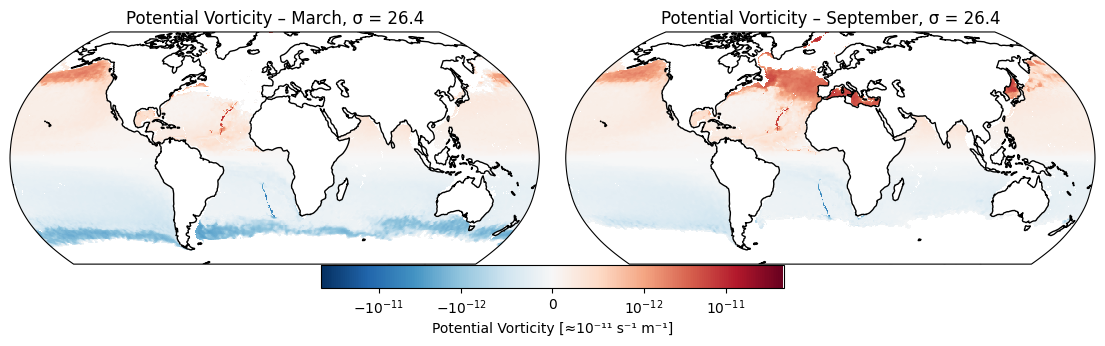

In [4]:

# Compute for March & September
p_sigma_mar, pv_sigma_mar = compute_surface_fields(ds, 3)
p_sigma_sep, pv_sigma_sep = compute_surface_fields(ds, 9)

# Global Plot
fig, axes = plt.subplots(
    1, 2,
    figsize=(14, 6),
    subplot_kw={"projection": ccrs.Robinson()}
)

min_val, max_val = -5e-11, 5e-11
color_norm = SymLogNorm(linthresh=1e-12, linscale=1, vmin=min_val, vmax=max_val)

for ax, field, title in [
    (axes[0], pv_sigma_mar, "March, σ = 26.4"),
    (axes[1], pv_sigma_sep, "September, σ = 26.4"),
]:
    im = field.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r",
        norm=color_norm,
        add_colorbar=False,
    )
    ax.coastlines()
    ax.set_title(f"Potential Vorticity – {title}")

cbar = fig.colorbar(im, ax=axes, orientation="horizontal", fraction=0.05, pad=0.05)
cbar.set_label("Potential Vorticity [≈10⁻¹¹ s⁻¹ m⁻¹]")

plt.subplots_adjust(wspace=0.05, bottom=0.15)
plt.show()


## northern/southern hemisphere plots of potential vorticity on density surface 26.4 kg/m3 for March/September

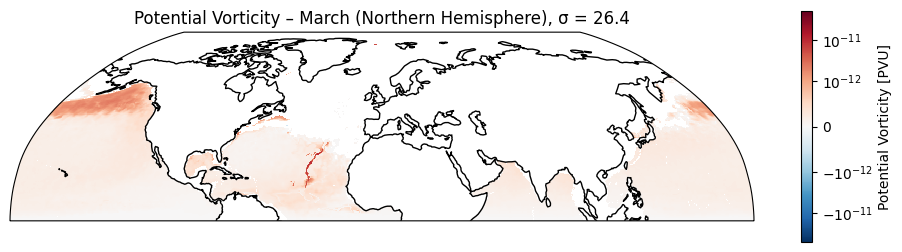

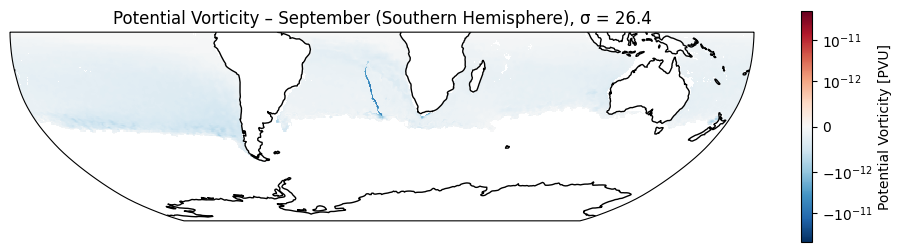

In [5]:
# March: Northern Hemisphere
pv_march_nh = pv_sigma_mar.sel(LATITUDE=slice(0, 90))

vmin, vmax = -5e-11, 5e-11

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())

pv_march_nh.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    norm=SymLogNorm(linthresh=1e-12, linscale=1, vmin=vmin, vmax=vmax),
    cbar_kwargs={
        "shrink": 0.5,
        "pad": 0.05,
        "label": "Potential Vorticity [PVU]"
    },
)

ax.coastlines()
ax.set_title("Potential Vorticity – March (Northern Hemisphere), σ = 26.4")
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
plt.show()

# September: Southern Hemisphere 
pv_sept_sh = pv_sigma_sep.sel(LATITUDE=slice(-90, 0))

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())

pv_sept_sh.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    norm=SymLogNorm(linthresh=1e-12, linscale=1, vmin=vmin, vmax=vmax),
    cbar_kwargs={
        "shrink": 0.5,
        "pad": 0.05,
        "label": "Potential Vorticity [PVU]"
    },
)

ax.coastlines()
ax.set_title("Potential Vorticity – September (Southern Hemisphere), σ = 26.4")
ax.set_extent([-180, 180, -90, 0], crs=ccrs.PlateCarree())
plt.show()

## Global maps: depth of σ = 26.4 surface

/home/lisa/Documents/THC/Thermohaline-Circulation/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: overflow encountered in ct_from_t
  result_data = func(*input_data)
/home/lisa/Documents/THC/Thermohaline-Circulation/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in ct_from_t
  result_data = func(*input_data)
/home/lisa/Documents/THC/Thermohaline-Circulation/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: overflow encountered in ct_from_t
  result_data = func(*input_data)
/home/lisa/Documents/THC/Thermohaline-Circulation/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in ct_from_t
  result_data = func(*input_data)


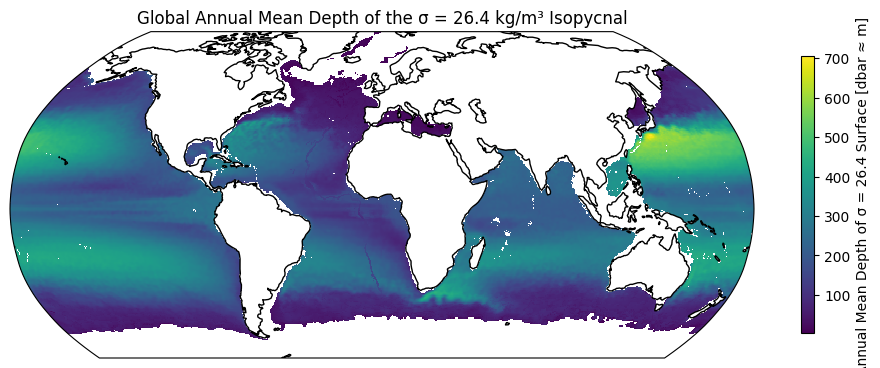

In [6]:
# Compute p_sigma for all 12 months

monthly_depths = []

for month in range(1, 13):
    p_sigma, _ = compute_surface_fields(ds, month)   # we only need p(σ)
    monthly_depths.append(p_sigma)

# Stack into a new dimension TIME
depth_sigma_all = xr.concat(monthly_depths, dim="TIME")
depth_sigma_all["TIME"] = np.arange(1, 13)

# Annual mean depth
depth_sigma_annual = depth_sigma_all.mean(dim="TIME")

# Plot global annual mean depth
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())

im = depth_sigma_annual.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    add_colorbar=True,
    cbar_kwargs={
        "shrink": 0.6,
        "pad": 0.05,
        "label": "Annual Mean Depth of σ = 26.4 Surface [dbar ≈ m]"
    },
)

ax.coastlines()
ax.set_title("Global Annual Mean Depth of the σ = 26.4 kg/m³ Isopycnal")
plt.show()


## Discussion
The density surface map shows where the σ = 26.4 surface is. It's found close to the surface in the mixed layer (low pressure) compared to deep inside the thermocline (high pressure).
In subtropical regions, the isopycnal tends to be deepest, associated with mode waters and strong stratification. The western boundary currents, Kuroshio and Agulhas, and the Gulf Stream weaker, show strong gradients, which is a sign of dynamic areas.
In high-latitude regions, the σ = 26.4 surface is much shallower. 
